In [0]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from torch.distributions import Categorical
import random
from collections import namedtuple
from tqdm import tqdm_notebook as tqdm

In [2]:
!apt install swig
!pip install box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 32 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (842 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpacking 

In [0]:
env = gym.make('LunarLander-v2')

In [3]:
num_state = env.observation_space.shape[0]
num_action = env.action_space.n
num_state, num_action

(8, 4)

### Model

In [0]:
class network(nn.Module):
    
    def __init__(self ,num_state ,num_action):
        
        super().__init__()
        self.fc1 = nn.Linear(num_state , 64)
        self.fc2 = nn.Linear(64 , 64)
        self.fc3 = nn.Linear(64 , 32)
        self.out = nn.Linear(32 , num_action)
        
    def forward(self , x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

class DuelingDQN(nn.Module):
    def __init__(self, num_state, num_action):
        super(DuelingDQN, self).__init__()
        
        self.feature = nn.Sequential(
            nn.Linear(num_state, 64),
            nn.ReLU()
        )
      
        self.advantage = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, num_action)
        )
        
        self.value = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value     = self.value(x)
        return value + advantage  - advantage.mean()


class ReplayBuffer(object):
    '''
    
    This code is copied from openAI baselines
    https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
    '''
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes , dtype = np.float32):
        
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False,dtype=dtype))
            actions.append(np.array(action, copy=False,dtype=np.long))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False,dtype=dtype))
            dones.append(done)
        return np.array(obses_t,dtype=dtype), np.array(actions , dtype = np.long), \
    np.array(rewards  ,dtype=dtype), np.array(obses_tp1,dtype=dtype), np.array(dones , dtype = bool)
    
    
    def sample(self, batch_size):
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

    
class Agent():
    
    def __init__(self , num_state , num_action):
        
        # self.policy_network = network(num_state , num_action)
        # self.target_network = network(num_state , num_action)
        
        self.policy_network = DuelingDQN(num_state , num_action)
        self.target_network = DuelingDQN(num_state , num_action)

        self.target_network.load_state_dict(self.policy_network.state_dict())
        
        self.steps_done = 0
        self.num_state = num_state
        self.num_action = num_action
        
        self.EPS_END = 0.05
        self.EPS_START = 0.999
        self.EPS_DECAY = 1000
        # self.epsilon = 1.0
        # self.epsilon_decay = 0.999
        # self.epsilon_min = 0.05
        # self.gamma = 0.999

        self.batch_size = 64
        self.buffer = ReplayBuffer(60000)
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(),lr=0.01, amsgrad=True)
        
    def take_action(self , x , is_testing = False ) :
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)

        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        rand_val = np.random.uniform()

        if rand_val > eps_threshold or is_testing == True:
        # if rand_val <= self.epsilon or is_testing == True:
            val = self.policy_network(x)
            action = torch.argmax(val).item()
        else:
            action = np.random.randint(0 , self.num_action )
        
        if is_testing == False:
            self.steps_done += 1
        
        return action
            
    
    def store_transition(self, state , action , reward , next_state , done ):
        
        self.buffer.add(state , action , reward , next_state , done)
    
    
    def update_parameters(self):
        
        if len(self.buffer) < self.batch_size:
            return 
        
        loss_fn = torch.nn.MSELoss(reduction = 'mean')
        
        batch = self.buffer.sample(self.batch_size)
        states , actions , rewards , next_states , dones = batch
        states = torch.from_numpy(states)
        actions = torch.from_numpy(actions).view(-1,1)
        rewards = torch.from_numpy(rewards)
        next_states = torch.from_numpy(next_states)
        actions = actions.long()
        
        non_final_mask = torch.tensor(tuple(map(lambda s : s != True, dones)),dtype = torch.bool)
        non_final_next_state = next_states[non_final_mask]
        
        
        pred_q = self.policy_network(states).gather(1 , actions).view(-1) 
        
        
        next_state_value = torch.zeros(self.batch_size).detach()
        next_state_value[non_final_mask] = self.target_network(non_final_next_state).max(1)[0]
        expected_q = (next_state_value + rewards).detach()
        # expected_q = (self.gamma * next_state_value + rewards).detach()
        
        
        loss = loss_fn(pred_q , expected_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def update_target_weight(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

### For remote display

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

#installing dependencies
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'


In [0]:
# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display)
# + "." + str(display.screen)

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Training

In [18]:
agent = Agent(num_state , num_action)
reward_history = []
success_count = 0
flag=0
try:
    env = gym.make('LunarLander-v2')
    for e in tqdm(range(3001)):
        state = env.reset()
        done = False
        reward_sum = 0.0
        while done == False:
            
            action = agent.take_action(state)
            next_state , reward , done , _ = env.step(action)
            if (reward == 100):
                success_count += 1
            reward_sum += reward

            agent.store_transition(state , action , reward , next_state , done )
            state = next_state[:]
            agent.update_parameters()
            
        reward_history.append(reward_sum)

        # epsilon decay
        # if agent.epsilon > agent.epsilon_min:
        #     agent.epsilon *= agent.epsilon_decay

        if e > 0 and e % 20 == 0:
            agent.update_target_weight()

        if e % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(e, np.mean(reward_history)))
            print(success_count)
            success_count = 0
        if np.mean(reward_history[-100:])>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e-100, np.mean(reward_history)))
            torch.save(agent.policy_network.state_dict(), '/content/gdrive/My Drive/dqn_ep_{}.pth'.format(e))
            print('dqn_ep_{} model saved'.format(e))
            flag=1
            break
        
finally:
    env.close()
    if (flag==0):
       torch.save(agent.policy_network.state_dict(), '/content/gdrive/My Drive/dqn_end.pth')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Episode 0	Average Score: -123.29
0
Episode 100	Average Score: -147.15
6
Episode 200	Average Score: -123.96
5
Episode 300	Average Score: -113.61
2
Episode 400	Average Score: -114.07
11
Episode 500	Average Score: -101.40
20
Episode 600	Average Score: -86.71
22
Episode 700	Average Score: -72.16
34
Episode 800	Average Score: -57.09
44
Episode 900	Average Score: -39.91
52
Episode 1000	Average Score: -23.99
60
Episode 1100	Average Score: -12.89
59
Episode 1200	Average Score: -0.50
67
Episode 1300	Average Score: 10.28
68
Episode 1400	Average Score: 21.14
72
Episode 1500	Average Score: 30.65
71

Environment solved in 1480 episodes!	Average Score: 38.97
dqn_ep_1580 model saved


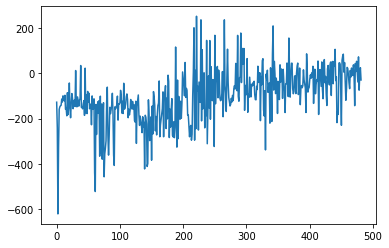

In [0]:
import matplotlib.pyplot as plt
plt.plot(reward_history)

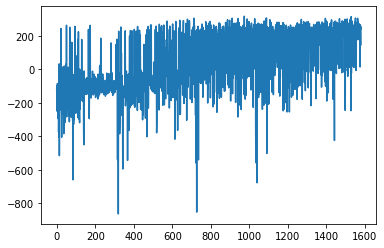

In [19]:
import matplotlib.pyplot as plt
plt.plot(reward_history)

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')
#using model.save_weights() to save the weights of the model in HDF5 format
# model.save_weights("/content/gdrive/My Drive/weights.h5")

### Testing

In [0]:
model_path = '/content/gdrive/My Drive/dqn_ep_1580.pth'
# 
# cur_model = network(num_state , num_action)
cur_model = DuelingDQN(num_state , num_action)
cur_model.load_state_dict(torch.load(model_path))

agent = Agent(num_state , num_action)
agent.policy_network = cur_model

test_episode: 0 reward_sum: 288.18767925612406
test_episode: 1 reward_sum: 242.91008500432693


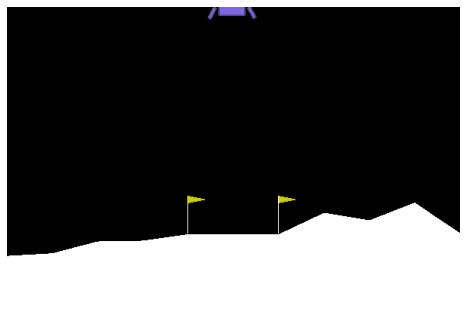

In [8]:
frames = []
env = gym.make('LunarLander-v2')
for i in range(2):
    state = env.reset()
    done = False
    rew_sum = 0.0
    t = 0
    while done == False and t <= 1000:
        frames.append(env.render(mode = 'rgb_array'))
        action = agent.take_action(state , is_testing = True)
        next_state , reward , done , _ = env.step(action)
        rew_sum += reward
        state = next_state[:]
        t +=1

    print('test_episode:', i, 'reward_sum:', rew_sum)
    
env.render()
env.close()

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())